In [1]:
pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 465.5 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.12.0-py3-none-any.whl (234 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4227141 sha256=0ad22c2e3a5ad1afd3278c0c59c38aae4d30cacf4291e4ce88c57bc3962e65cb
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [ ]:
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, Dense, Embedding, Bidirectional, Dropout, Conv1D, GlobalMaxPooling1D, Masking, Reshape, Input, concatenate, Flatten, BatchNormalization, Attention, Dot, Concatenate
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras import regularizers
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import time
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
import fasttext

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

In [21]:
df=pd.read_csv('train.csv')
df=df.fillna(value='')
labels=np.array(df['label'])
premise=df['premise'].tolist()
hypothesis=df['hypothesis'].tolist()

lemmatizer = WordNetLemmatizer()
p_pre=[]
h_pre=[]
#Do not remove stop words.
for i in range(len(premise)):
  p_token=[word for word in premise[i] if word not in string.punctuation]
  p_token=[word.lower() for word in p_token]
  #p_token=[word for word in p_token if word not in stop_words]
  lemma_p=[lemmatizer.lemmatize(word) for word in p_token]
  p_pre.append(lemma_p)

  h_token=[word for word in hypothesis[i] if word not in string.punctuation]
  h_token=[word.lower() for word in h_token]
  #h_token=[word for word in h_token if word not in stop_words]
  lemma_h=[lemmatizer.lemmatize(word) for word in h_token]
  h_pre.append(lemma_h)

texts=p_pre+h_pre
tokenizer=Tokenizer(num_words=10000)
tokenizer.fit_on_texts(texts)
vocab_size=10000

max_sequence_length=120
p_seq=tokenizer.texts_to_sequences(p_pre)
padded_p=pad_sequences(p_seq, maxlen=max_sequence_length, padding='post', truncating='post')
h_seq=tokenizer.texts_to_sequences(h_pre)
padded_h=pad_sequences(h_seq, maxlen=max_sequence_length, padding='post', truncating='post')



In [22]:
#Fasttext pretrained embedding.
with open('text_data.txt', 'w') as f:
    for text in texts:
        f.write(' '.join(map(str, text))+'\n')
v2v=fasttext.train_unsupervised('text_data.txt', model='skipgram', dim=64, epoch=30, minCount=5, lr=0.05)


In [23]:
embedding_dim=64
input_premise = Input(shape=(max_sequence_length,))
input_hypothesis = Input(shape=(max_sequence_length,))

#FastText Embedding
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = v2v.get_word_vector(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix])

embedded_premise = embedding_layer(input_premise)
embedded_hypothesis = embedding_layer(input_hypothesis)

#Do not Change pretrained embedding parameters.
embedding_layer.trainable=False

# BiLSTM
lstm_layer = Bidirectional(LSTM(units=64, return_sequences=True))
lstm_output_premise = lstm_layer(embedded_premise)
lstm_output_hypothesis = lstm_layer(embedded_hypothesis)

# MaxPooling
pooling_premise = GlobalMaxPooling1D()(lstm_output_premise)
pooling_hypothesis = GlobalMaxPooling1D()(lstm_output_hypothesis)

output = Dense(units=2, activation='softmax')(Concatenate()([pooling_premise, pooling_hypothesis]))

model = Model(inputs=[input_premise, input_hypothesis], outputs=output)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 120)]                0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 120)]                0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, 120, 64)              640000    ['input_7[0][0]',             
                                                                     'input_8[0][0]']             
                                                                                                  
 bidirectional_3 (Bidirecti  (None, 120, 128)             66048     ['embedding_3[0][0]',   

In [24]:
def prep(file):
  df=pd.read_csv(file)
  df=df.fillna(value='')
  labels=np.array(df['label'])
  premise=df['premise'].tolist()
  hypothesis=df['hypothesis'].tolist()

  lemmatizer = WordNetLemmatizer()
  p_pre=[]
  h_pre=[]
  for i in range(len(premise)):
    p_token=[word for word in premise[i] if word not in string.punctuation]
    p_token=[word.lower() for word in p_token]
    #p_token=[word for word in p_token if word not in stop_words]
    lemma_p=[lemmatizer.lemmatize(word) for word in p_token]
    p_pre.append(lemma_p)

    h_token=[word for word in hypothesis[i] if word not in string.punctuation]
    h_token=[word.lower() for word in h_token]
    #h_token=[word for word in h_token if word not in stop_words]
    lemma_h=[lemmatizer.lemmatize(word) for word in h_token]
    h_pre.append(lemma_h)

  texts=p_pre+h_pre
  tokenizer=Tokenizer(num_words=10000)
  tokenizer.fit_on_texts(texts)
  vocab_size=10000

  max_sequence_length=120
  p_seq = tokenizer.texts_to_sequences(p_pre)
  padded_p = pad_sequences(p_seq, maxlen=max_sequence_length, padding='post', truncating='post')
  h_seq = tokenizer.texts_to_sequences(h_pre)
  padded_h = pad_sequences(h_seq, maxlen=max_sequence_length, padding='post', truncating='post')

  return padded_p, padded_h, labels

dev_p, dev_h, dev_labels=prep('dev.csv')

In [25]:
#train the model and evaluate on dev.
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
start=time.time()
stasts=model.fit([padded_p, padded_h], labels, epochs=20, batch_size=64, validation_data=([dev_p, dev_h], dev_labels))
end=time.time()
excecution_time=round(end-start, 3)
print(f'The training time is {excecution_time}s.')

Epoch 1/20
421/421 [==============================] - 146s 330ms/step - loss: 0.6779 - accuracy: 0.5672 - val_loss: 0.6717 - val_accuracy: 0.5725
Epoch 2/20
421/421 [==============================] - 139s 331ms/step - loss: 0.6729 - accuracy: 0.5731 - val_loss: 0.6775 - val_accuracy: 0.5695
Epoch 3/20
421/421 [==============================] - 135s 322ms/step - loss: 0.6693 - accuracy: 0.5833 - val_loss: 0.6706 - val_accuracy: 0.5830
Epoch 4/20
421/421 [==============================] - 134s 319ms/step - loss: 0.6674 - accuracy: 0.5847 - val_loss: 0.6733 - val_accuracy: 0.5768
Epoch 5/20
421/421 [==============================] - 140s 333ms/step - loss: 0.6664 - accuracy: 0.5897 - val_loss: 0.6735 - val_accuracy: 0.5774
Epoch 6/20
421/421 [==============================] - 126s 300ms/step - loss: 0.6631 - accuracy: 0.5965 - val_loss: 0.6654 - val_accuracy: 0.5957
Epoch 7/20
421/421 [==============================] - 135s 322ms/step - loss: 0.6559 - accuracy: 0.6075 - val_loss: 0.6553 -

In [34]:
model.save('BiLSTM.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


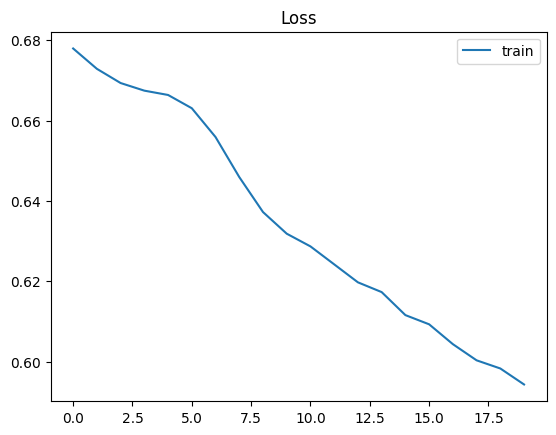

In [27]:
plt.title('Loss')
plt.plot(stasts.history['loss'], label='train')
plt.legend()
plt.show()

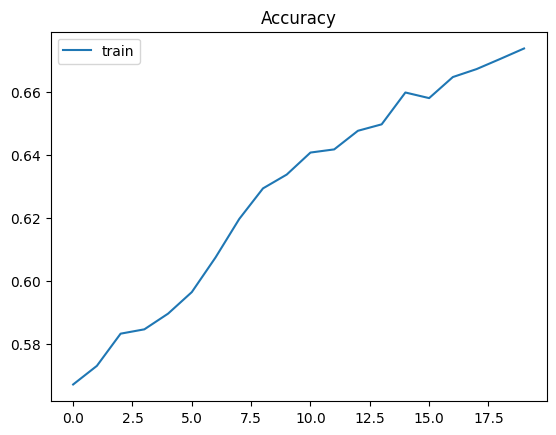

In [28]:
plt.title('Accuracy')
plt.plot(stasts.history['accuracy'], label='train')
plt.legend()
plt.show()

In [29]:
loss_dev, accuracy_dev = model.evaluate([dev_p, dev_h], dev_labels)

211/211 [==============================] - 16s 76ms/step - loss: 0.6318 - accuracy: 0.6369


In [ ]:
dev_pred=model.predict([dev_p, dev_h])
dev_ps=np.argmax(dev_pred, axis=1)
df_dev=pd.DataFrame({'prediction': dev_ps})
df_dev.to_csv('dev_prediction.csv', index=False)

In [33]:
from sklearn.metrics import f1_score, precision_score, recall_score

precision=precision_score(dev_labels, dev_ps)
recall=recall_score(dev_labels, dev_ps)
f1 = f1_score(dev_labels, dev_ps)
print(precision)
print(recall)
print(f1)

0.6245173745173745
0.7441058079355952
0.6790868538441355
